<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Introduction to Logistic Regression

_Authors: Kiefer Katovich (SF), Matt Brems (DC)_

---

### Learning Objectives
- Understand how logistic regression is similar to and different than regression
- Understand the math behind the logit link function (and logistic function)
- Code the calculation of the odds ratio and log-odds ratio
- Plot the logistic regression for predicting admittance from GPA
- Understand how to interpret the coefficients of logistic regression
- Know the benefits of logistic regression as a classifier



### Lesson Guide
- [Introduction](#introduction)
- [Load the college admissions data](#load-data)
- [Regression models estimate the expected value of y](#expected-value)
- [What happens if we predict "admit" with "gpa" using linear regression?](#pred-admit)
    - [Plot the regression line](#plot-reg)
- [Predicting a binary class](#pred-binary)
- [The logit link function](#logit-link)
    - [Aside: odds ratios](#odds-ratios)
    - [Step 1: the odds ratio in place of y](#odds-ratio-inplace)
    - [Step 2: the log-odds instead of the odds ratio](#log-odds)
- [The logistic function](#logistic)
- [Logistic regression prediction line visually](#logistic-viz)
- [Solving for the beta coefficients](#solving-beta)
- [Interpreting logistic regression coefficients](#interpreting)
- [Conclusion](#conclusion)
- [Additional resources](#resources)

<a id='introduction'></a>

## Introduction

---

Logistic regression is a famous classifier still used frequently today, despite its age. It _is_ a regression, but don't let that confuse you: it operates as a classifier. It estimates probabilities of class membership.

In this lecture we will only be reviewing the binary outcome case with two classes, but logistic regression can be generalized to multiple classes.

**Some examples of when logistic regression could be used:**
- Predict whether or not a user will purchase a product given their demographic characteristics.
- Predict the likelihood of a student being admitted to a college, given their scores and the characteristics of the college.
- Diagnose a patient with a disease or not, given symptoms.
- Predict whether a person will default on a loan and with what likelihood.

And many more. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm

/Users/jmpounders/anaconda2/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Some nice colors we can use in our plots:
colors = {'blue': '#729ECE',
          'brown': '#A8786E',
          'green': '#67BF5C',
          'grey': '#A2A2A2',
          'orange': '#FF9E4A',
          'pink': '#ED97CA',
          'purple': '#AD8BC9',
          'red': '#ED665D',
          'teal': '#6DCCDA',
          'yellow': '#CDCC5D'}

<a id='load-data'></a>

## Load the college admissions data

---

As we walk through the inner workings of logistic regression, we will be using some basic college admissions data. The data only has a few columns:
- `admit`: a binary 1-0 variable indicating whether a student was admitted
- `gre`: the student's GRE score
- `gpa`: the student's GPA
- `prestige`: a rating for the college applied to's "prestige"

**Load in the data and do any neccessary cleaning.**

In [3]:
admissions = pd.read_csv('./datasets/admissions.csv')

In [4]:
admissions.head(3)

,admit,gre,gpa,prestige
0,0,380.0,3.61,3.0
1,1,660.0,3.67,3.0
2,1,800.0,4.00,1.0


In [5]:
admissions.isnull().sum()

admit       0
gre         2
gpa         2
prestige    1
dtype: int64

In [6]:
admissions.dropna(inplace=True)

### Artificially increase the signal in the data

The signal for detecting admission in the college data is fairly weak. Too weak for demonstration purposes. Below I not only multiply the dataset by 10x, but add some artificial signal for detecting `admit` to the `gpa` column. 

*Obviously* you would never do this to your real data.

In [7]:
admit = admissions[admissions.prestige == 1]

admit = pd.concat([admit]*10, axis=0)

admit.loc[admit.admit == 1, 'gpa'] += np.random.random(size=admit[admit.admit == 1].shape[0])
admit.loc[admit.admit == 0, 'gpa'] -= np.random.random(size=admit[admit.admit == 0].shape[0])

<a id='expected-value'></a>

## Regression models estimate the expected value of `y`

---

Logistic regression is a regression. It still constructs a formula with our predictor variables and coefficients to estimate the *expected value* of the target variable.

You are quite familiar with linear regression. I've re-written the formula slightly on the left-hand side:

### $$E(y|X) = \beta_0 + \sum_{j}^p\beta_jx_j$$

Where:
- $E(y|X)$ is the expected value (mean) of y given corresponding predictor values in matrix $X$
- $\sum_{j}^p$ are the predictors $j$ thru $p$ (columns) of the $X$ matrix
- $\beta_0$ is the intercept
- $\beta_j$ is the coefficient for the predictor $x_j$, the $j$th column in variable matrix $X$


<a id='pred-admit'></a>

## What if we predicted `admit` with `gpa` using linear regression?

---

Let's try predicting the `admit` binary indicator using just `gpa` with a Linear Regression to see what goes wrong.

In [8]:
y = admit.admit.values
X = admit[['gpa']].values

linmod = LinearRegression()
linmod.fit(X, y)

print('Intercept:', linmod.intercept_)
print('Coef(s):', linmod.coef_)

Intercept: -1.25329656312
Coef(s): [ 0.51499842]


<a id='plot-reg'></a>
### What do those coefficients mean?  Plot `admit ~ gpa`

How can we interpret these coefficients when we know that `admit` is either 0 or 1? Looking at the plot below, what is the apparent problem with using a regression?

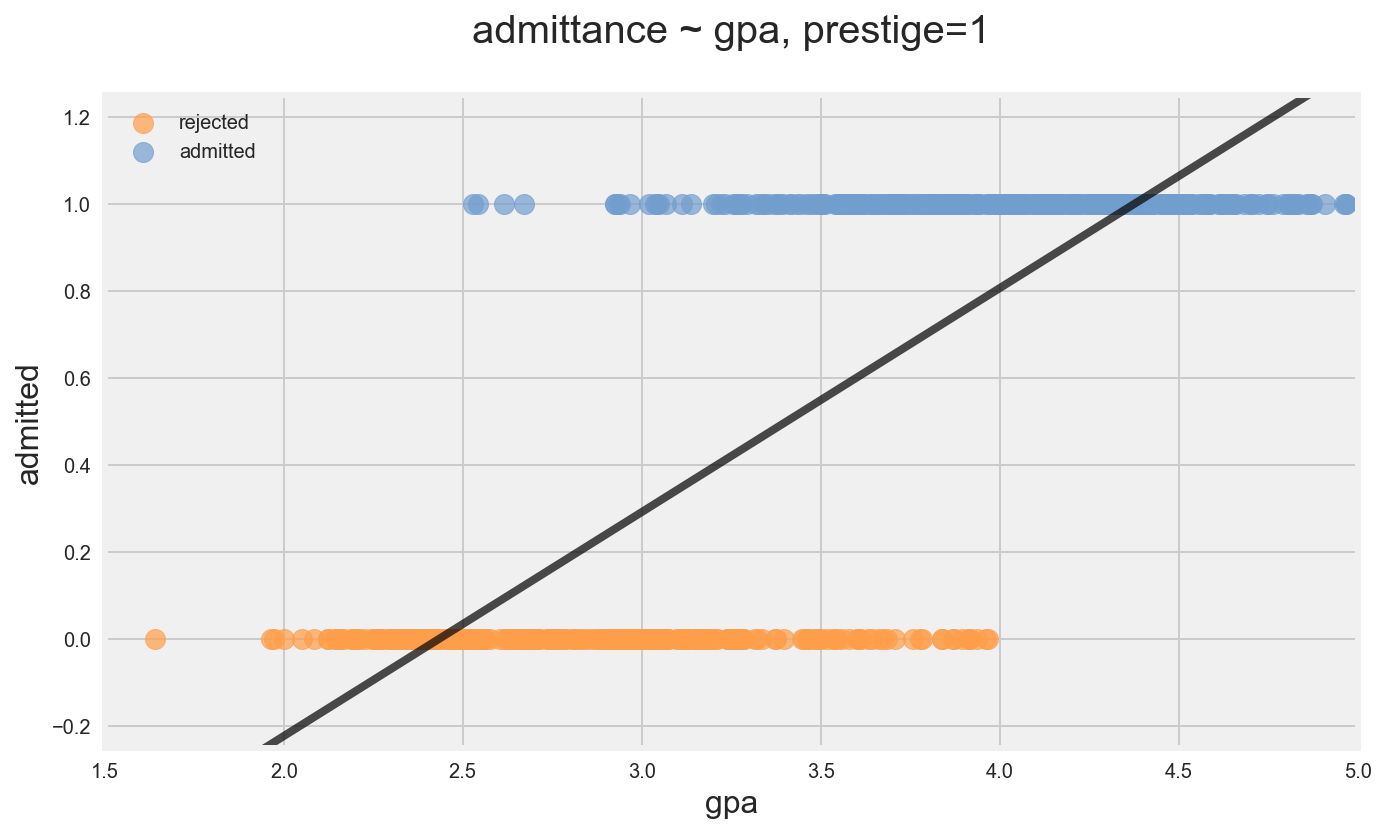

In [9]:
fig, ax = plt.subplots(figsize=(10,6))
#fig.set_size_inches(6,5)

# plot the regression line for admit ~ gpa
x_vals = np.linspace(1.,5.,300)
ax.plot(x_vals, linmod.predict(x_vals[:, np.newaxis]),
        color='black', alpha=0.7, lw=4)

# do one scatter plot for each type of wine:
ax.scatter(admit.gpa[admit.admit == 0],
           admit.admit[admit.admit == 0],
           c=colors['orange'], s=100, alpha=0.7,
           label='rejected')

ax.scatter(admit.gpa[admit.admit == 1],
           admit.admit[admit.admit == 1],
           c=colors['blue'], s=100, alpha=0.7,
           label='admitted')

ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('admittance ~ gpa, prestige=1\n', fontsize=20)

ax.set_xlim([1.5,5])
ax.set_ylim(-0.25, 1.25)

plt.legend(loc='upper left')
plt.show()

<a id='pred-binary'></a>

## Predicting a binary class

---

In our case we have two classes `1=admitted` and `0=rejected`.

The logistic regression is still solving for an expected value. In our binary classification case this expected value is the probability of `y` being one of the classes.

### $$E(y) = P(y = 1)$$

As you can see, we still represent this with a regression on the right side.

### $$E(y|X) = P(y = 1|X) = \beta_0 + \sum_{j}^p\beta_jx_j$$

There is a clear problem with this, which we saw in the previous plot. The right side of the equation is in no way bounded to [0, 1]. We need to *guarantee* that the right-hand side of the regression equation will evaluate to a probability estimate.

<a id='logistic'></a>
## How do we get probabilities out? 

---

### $$P(y=1 | X) = \frac{e^{\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)}}{e^{\left(\beta_0 + \sum_{j}^p\beta_jx_j\right)}+1}$$

<a id='logistic-viz'></a>

## The logistic regression prediction line visually

---

Let's plot the prediction of `admit` using sklearn's `LogisticRegression` class and see what the regression line looks like.

In [10]:
y = admit.admit.values
X = admit[['gpa']].values

logreg = LogisticRegression()
logreg.fit(X, y)

print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)
print('Logreg predicted probabilities:', logreg.predict_proba(X[0:5,:]))

Logreg intercept: [-8.27186285]
Logreg coef(s): [[ 2.47120879]]
Logreg predicted probabilities: [[ 0.12461088  0.87538912]
 [ 0.64096096  0.35903904]
 [ 0.68882515  0.31117485]
 [ 0.0469511   0.9530489 ]
 [ 0.1256851   0.8743149 ]]


In [11]:
# 0 = b0 + b1x
# -b0 = b1x
# -b0/b1 = x

decision_bdry = (-logreg.intercept_[0])/logreg.coef_[0][0]
print(decision_bdry)

logreg.predict_proba([[decision_bdry]])

3.34729420456


array([[ 0.5,  0.5]])

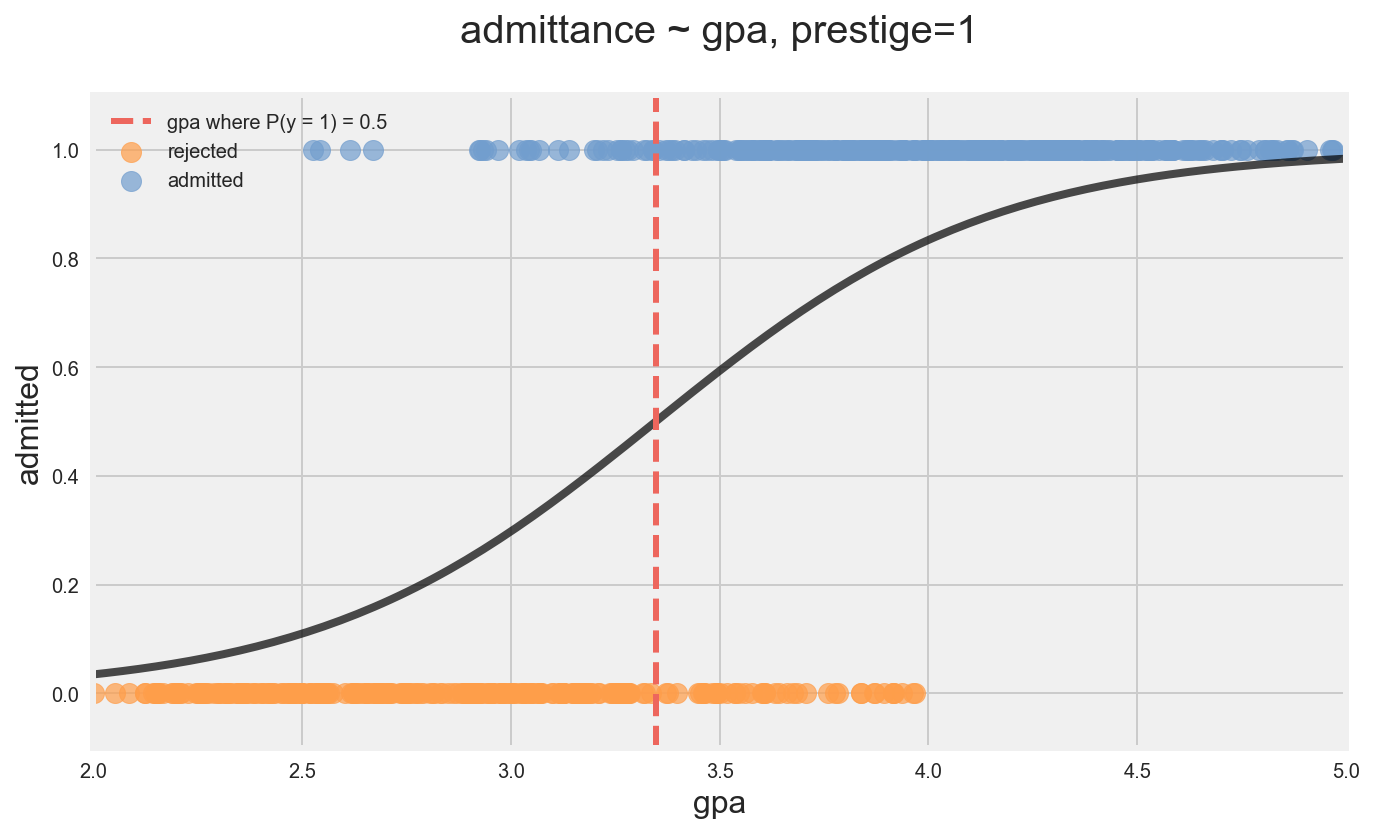

In [12]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the logreg regression line for admit ~ gpa
x_vals = np.linspace(-1.,5.,300)
y_pp = logreg.predict_proba(x_vals[:, np.newaxis])[:,1]

ax.plot(x_vals, y_pp, color='black', alpha=0.7, lw=4)

# do one scatter plot for each type of wine:
ax.scatter(admit.gpa[admit.admit == 0],
           admit.admit[admit.admit == 0],
           c=colors['orange'], s=100, alpha=0.7,
           label='rejected')

ax.scatter(admit.gpa[admit.admit == 1],
           admit.admit[admit.admit == 1],
           c=colors['blue'], s=100, alpha=0.7,
           label='admitted')

ax.axvline(decision_bdry, lw=3, color=colors['red'], ls='dashed',
           label='gpa where P(y = 1) = 0.5')

ax.set_ylabel('admitted', fontsize=16)
ax.set_xlabel('gpa', fontsize=16)
ax.set_title('admittance ~ gpa, prestige=1\n', fontsize=20)

ax.set_xlim([2.,5.])
ax.set_ylim([-0.1, 1.1])

plt.legend(loc='upper left')
plt.show()

<a id='solving-beta'></a>
## Solving for the beta coefficients

---

Logistic regression minimizes the "deviance", which is analagous to the residual sum of squares in linear regression. There is not a closed-form solution to the beta coefficients like in linear regression, and the betas are found through optimization procedures.

If you are particularly interested in the math, these two resources are good:

[A good blog post on the logistic regression beta coefficient derivation.](http://www.win-vector.com/blog/2011/09/the-simpler-derivation-of-logistic-regression/)

[This paper is also a good reference.](https://www.stat.cmu.edu/~cshalizi/402/lectures/14-logistic-regression/lecture-14.pdf)



<a id='interpreting'></a>

## Interpreting logistic regression coefficients

---

The interpretation of logistic regression coefficients can be a little confusing due to the logistic function.

**To make it easier, start by centering your predictor variables (subtracting the mean):**

In [15]:
Xs = X - X.mean()
print(Xs[0:5, :])

[[ 0.65211845]
 [-0.37127139]
 [-0.45831183]
 [ 1.08149823]
 [ 0.64814812]]


#### Why does centering matter?

Centering helps a lot because now the "baseline" for the predictor, the value at 0, is the mean of the predictor. So, in our case, when gpa = 0 this is the average gpa across students.

After re-running the regression we can take a look at the coefficients:

In [16]:
logreg = LogisticRegression()
logreg.fit(Xs, y)

print('Logreg intercept:', logreg.intercept_)
print('Logreg coef(s):', logreg.coef_)

Logreg intercept: [ 0.31150476]
Logreg coef(s): [[ 3.99324694]]


#### Meaning of the betas in log odds

Remember that our values are in terms of log-odds. 

> If $\beta_1$ is 0, then $\beta_0$ represents the log odds of admittance for a student with an average gpa.

> $\beta_1$ is the effect of a unit increase in gpa on the log odds of admittance. 

This sucks because log odds are hard to interpret. Luckily though, we can apply the logistic transform to get the probability of admittance at different $\beta$ values.

In [17]:
intercept = 0.
x = 1.
beta = 2.
y_hat = intercept + x*beta
print(y_hat)
np.exp(intercept + beta*x)/(1+ np.exp(intercept + beta*x))

2.0


0.88079707797788243

In [18]:
def logistic_transformation(gpa, b0, b1):
    regression_sum = b0 + b1*gpa
    exponentiated = np.exp(regression_sum)
    return exponentiated / (1 + exponentiated)
    

The probability of admittance with an average gpa:

In [19]:
print('average gpa:', np.mean(X[:,0]))
print('P(admitted | average gpa = 3.5):', logistic_transformation(0, logreg.intercept_[0], logreg.coef_[0][0]))

average gpa: 3.48404983449
P(admitted | average gpa = 3.5): 0.577252512893


In [28]:
logistic_transformation(-.5, logreg.intercept_[0], logreg.coef_[0][0])

0.21393302212035689

In [20]:
# 2.5 = mean_gpa + x
# 2.5 - mean_gpa = x
print('gpa = 2.5, difference from mean:', 2.5 - np.mean(X[:,0]))
print('P(admitted | gpa = 2.5):', logistic_transformation(2.5 - np.mean(X[:,0]), 
                                                          logreg.intercept_[0], logreg.coef_[0][0]))

gpa = 2.5, difference from mean: -0.984049834488
P(admitted | gpa = 2.5): 0.0261336777464


In [21]:
# 4.0 = mean_gpa + x
# 4.0 - mean_gpa = x
print('gpa = 4, difference from mean:', 4 - np.mean(X[:,0]))
print('P(admitted | gpa = 4):', logistic_transformation(4. - np.mean(X[:,0]), 
                                                        logreg.intercept_[0], logreg.coef_[0][0]))

gpa = 4, difference from mean: 0.515950165512
P(admitted | gpa = 4): 0.91465313405


** With more coefficients, setting $\beta$ values other than the one of interest to zero (except the intercept) will let you see the change in probability as the corresponding $x$ variable changes.**

<a id='conclusion'></a>

## Conclusion

---

The goal of logistic regression is to find the best fitting model to describe the relationship between the characteristic of interest (dependent variable = response or outcome variable) and a set of independent (predictor or explanatory) variables. 

Logistic regression generates the coefficients (and in statsmodels the standard errors and significance levels) of a formula to predict a logit transformation of the probability of presence of the characteristic of interest.

**Benefits of Logistic regression include:**
- Logistic regression is a classification algorithm that shares similar properties to linear regression
- It is very fast and efficient and is by far the most common classification algorithm
- The coefficients in a logistic regression model are interpretable (albeit somewhat complex): they represent the change in log-odds due to the input variables

<a id='resources'></a>

## Additional resources

---

- [Logistic Regression Video Walkthrough](https://www.youtube.com/watch?v=zAULhNrnuL4&noredirect=1)
- [Logistic Regression Walkthrough](http://www.mc.vanderbilt.edu/gcrc/workshop_files/2004-11-12.pdf)
- [Logistic Regression w/ Statsmodel - Well Switching in Bangledesh](http://nbviewer.ipython.org/urls/raw.github.com/carljv/Will_it_Python/master/ARM/ch5/arsenic_wells_switching.ipynb)
- [Odds Ratio Explanation](http://www.wright.edu/~thaddeus.tarpey/ES714glm.pdf)
- [0 and 1 are not probabilities](http://lesswrong.com/lw/mp/0_and_1_are_not_probabilities/)